In [23]:
import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))
import time

import warnings

warnings.filterwarnings("ignore")

In [24]:
import ee
import geemap

ee.Initialize(project="thurgau-irrigation")

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

from src.et_blue_per_field.etc_look_up_processing import (
    add_date_column,
    compute_et_ratio_timeseries,
    plot_multiple_et_ratio_timeseries,
    create_et_mask,
)

from utils.ee_utils import (
    back_to_float,
    back_to_int,
    export_image_to_asset,
    print_value_ranges,
    is_image_empty,
    fill_gaps_with_zeros,
    export_feature_collection,
    merge_collections,
    extract_pixel_values,
    aggregate_to_monthly,
)

from utils.date_utils import print_collection_dates, store_collection_dates

---

In [26]:
YEARS_TO_PROCESS = range(2018, 2022)

SCALING_FACTOR = 100

RIETHOLZBACH_VALIDATION = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021"
).sort("system:time_start")

point = RIETHOLZBACH_VALIDATION.first().geometry()

# oesnsingen_validation_et_collection = ee.FeatureCollection(
#     "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_oensingen_2004_2020"
# ).sort("system:time_start")

# oensingen_point = oesnsingen_validation_et_collection.first().geometry()


WAPOR_10M = merge_collections(
    asset_name="projects/thurgau-irrigation/assets/ET_products/Thurgau/WaPOR_10m",
    years=YEARS_TO_PROCESS,
).map(lambda img: back_to_float(img, SCALING_FACTOR))

WAPOR_300M = ee.ImageCollection(
    "projects/thurgau-irrigation/assets/ET_products/Thurgau/WaPOR_300m"
).filterDate("2018-01-01", "2022-01-01")

LANDSAT_30M = (
    ee.ImageCollection(
        "projects/thurgau-irrigation/assets/ET_products/StGallen/Landsat_dekadal_30m"
    )
    .filterDate("2018-01-01", "2022-01-01")
    .map(
        lambda img: back_to_float(img, 1, dynamic=True, scaling_factor_property="days")
    )
    .filterBounds(point.buffer(1000))
).sort("system:time_start")

In [27]:
LANDSAT_30M.size().getInfo()

print_collection_dates(LANDSAT_30M)

Dates of images in the collection:
2018-04-01
2018-04-11
2018-04-21
2018-05-01
2018-05-11
2018-05-21
2018-06-01
2018-06-11
2018-06-21
2018-07-01
2018-07-11
2018-07-21
2018-08-01
2018-08-11
2018-08-21
2018-09-01
2018-09-11
2018-09-21
2018-10-01
2018-10-11
2018-10-21
2019-04-01
2019-04-11
2019-04-21
2019-05-01
2019-05-11
2019-05-21
2019-06-01
2019-06-11
2019-06-21
2019-07-01
2019-07-11
2019-07-21
2019-08-01
2019-08-11
2019-08-21
2019-09-01
2019-09-11
2019-09-21
2019-10-01
2019-10-11
2019-10-21
2020-04-01
2020-04-11
2020-04-21
2020-05-01
2020-05-11
2020-05-21
2020-06-01
2020-06-11
2020-06-21
2020-07-01
2020-07-11
2020-07-21
2020-08-01
2020-08-11
2020-08-21
2020-09-01
2020-09-11
2020-09-21
2020-10-01
2020-10-11
2020-10-21
2021-04-01
2021-04-11
2021-04-21
2021-05-01
2021-05-11
2021-05-21
2021-06-01
2021-06-11
2021-06-21
2021-07-01
2021-07-11
2021-07-21
2021-08-01
2021-08-11
2021-08-21
2021-09-01
2021-09-11
2021-09-21
2021-10-01
2021-10-11
2021-10-21


In [28]:
# Map = geemap.Map()
# landsat_list = LANDSAT_30M.toList(LANDSAT_30M.size())

# image = ee.Image(landsat_list.get(13))

# Map.addLayer(image, {"min": 0, "max": 3, "palette": "viridis"}, "ET")
# Map.centerObject(image, 10)
# Map

In [29]:
dates_for_validation = store_collection_dates(WAPOR_10M)

## Validiation

In [30]:
rietholzbach_validation_df = geemap.ee_to_df(RIETHOLZBACH_VALIDATION)

In [31]:
def resample_and_interpolate_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample a DataFrame with a date column, setting daily frequency and interpolating missing values.

    Args:
        df (DataFrame): The input DataFrame containing a date column named 'date_[YYYYmmdd]'.

    Returns:
        DataFrame: A DataFrame resampled to daily frequency with interpolated values.
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date_[YYYYmmdd]"])
    df = df.drop(columns=["date_[YYYYmmdd]"])
    df = df.set_index("date")
    df = df.resample("D").asfreq()
    df = df.interpolate(method="time")
    return df


def aggregate_time_series(
    daily_data: pd.DataFrame,
    validation_dates: pd.DataFrame,
    aggregation_type: str = "mean",
) -> pd.DataFrame:
    """
    Aggregate daily time series data based on sample dates.

    Args:
        daily_data (pd.DataFrame): Daily time series with date index and 'evapotranspiration_[mm/d]' column.
        validation_dates (pd.DataFrame): DataFrame with 'date' column containing validation dates.
        aggregation_type (str): Type of aggregation to perform ('mean' or 'sum'). Defaults to 'mean'.

    Returns:
        pd.DataFrame: Aggregated data with sample dates and aggregated values.
    """
    daily_data.index = pd.to_datetime(daily_data.index)

    # Convert validation_dates to datetime and sort
    validation_dates["date"] = pd.to_datetime(validation_dates["date"])
    validation_dates = validation_dates.sort_values("date")

    # Create bins for grouping
    bins = validation_dates["date"].tolist() + [
        daily_data.index.max() + pd.Timedelta(days=1)
    ]

    # Cut the daily data into groups based on the bins
    daily_data["group"] = pd.cut(
        daily_data.index, bins=bins, labels=validation_dates["date"], right=False
    )

    # Group by the cut and calculate the aggregation
    if aggregation_type == "sum":
        aggregated_data = (
            daily_data.groupby("group")["evapotranspiration_[mm/d]"].sum().reset_index()
        )
        aggregated_data.columns = ["date", "sum_evapotranspiration_[mm/d]"]
    else:
        aggregated_data = (
            daily_data.groupby("group")["evapotranspiration_[mm/d]"]
            .mean()
            .reset_index()
        )
        aggregated_data.columns = ["date", "average_evapotranspiration_[mm/d]"]

    return aggregated_data

In [32]:
rietholzbach_validation_df = resample_and_interpolate_df(rietholzbach_validation_df)
rietholzbach_validation_df = aggregate_time_series(
    rietholzbach_validation_df, dates_for_validation
)

In [33]:
rietholzbach_validation_df["date"] = pd.to_datetime(rietholzbach_validation_df["date"])
rietholzbach_validation_df["average_evapotranspiration_[mm/d]"] = (
    rietholzbach_validation_df["average_evapotranspiration_[mm/d]"].round(0)
)

In [34]:
raster_collection_WaPOR_10m = extract_pixel_values(WAPOR_10M, point, band="downscaled")
raster_collection_WaPOR_300m = extract_pixel_values(WAPOR_300M, point, band="ET")
raster_collection_Landsat_30m = extract_pixel_values(LANDSAT_30M, point, band="ET")

In [35]:
LANDSAT_30M.first().bandNames().getInfo()

['ET']

In [36]:
def process_raster_collection(raster_collection: ee.FeatureCollection) -> pd.DataFrame:
    """
    Process a raster collection into a pandas DataFrame with evapotranspiration values.

    Args:
        raster_collection: Earth Engine raster collection

    Returns:
        pd.DataFrame: Processed DataFrame with evapotranspiration and date columns
    """
    # Convert to DataFrame
    df = geemap.ee_to_df(ee.FeatureCollection(raster_collection))

    # Process evapotranspiration values
    df["evapotranspiration[mm/d]"] = df["pixel_value"].round(0)

    # Convert date column
    df["date"] = pd.to_datetime(df["date"])

    return df


raster_df_WaPOR_10m = process_raster_collection(raster_collection_WaPOR_10m)
raster_df_WaPOR_300m = process_raster_collection(raster_collection_WaPOR_300m)
raster_df_Landsat_30m = process_raster_collection(raster_collection_Landsat_30m)

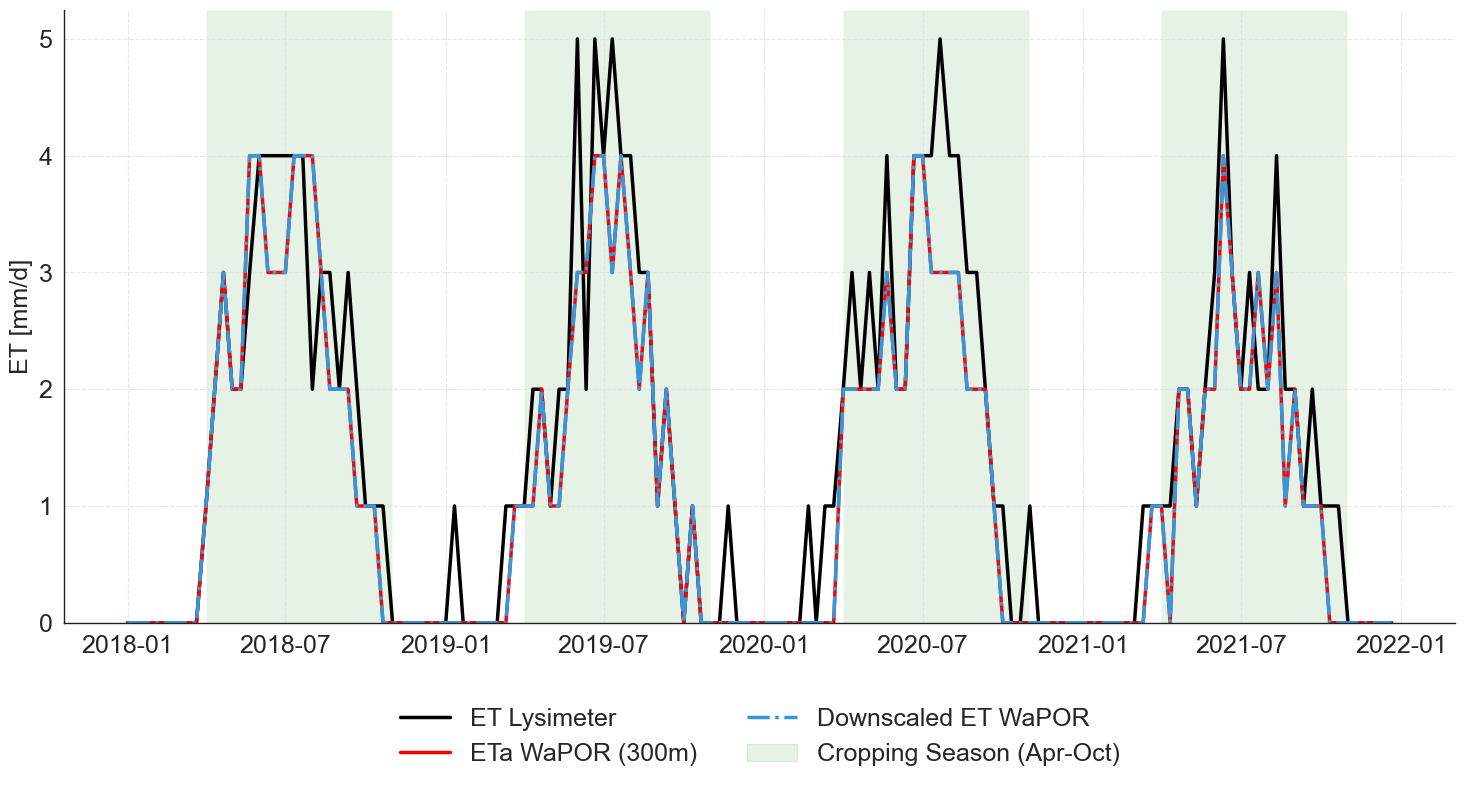

In [49]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
from utils.plot_config import set_plot_style

set_plot_style()

plt.figure(figsize=(15, 8))

# Plot the data
sns.lineplot(
    data=rietholzbach_validation_df,
    x="date",
    y="average_evapotranspiration_[mm/d]",
    label="ET Lysimeter",
    color="black",
)

sns.lineplot(
    data=raster_df_WaPOR_300m,
    x="date",
    y="evapotranspiration[mm/d]",
    label="ETa WaPOR (300m)",
    color="red",
    # color="#2ca02c",
)

sns.lineplot(
    data=raster_df_WaPOR_10m,
    x="date",
    y="evapotranspiration[mm/d]",
    label="Downscaled ET WaPOR",
    color="#3498db",
    linestyle="-.",
)


raster_df_Landsat_30m = raster_df_Landsat_30m[
    raster_df_Landsat_30m["evapotranspiration[mm/d]"] > 0
]
# sns.lineplot(
#     data=raster_df_Landsat_30m,
#     x="date",
#     y="evapotranspiration[mm/d]",
#     label="ETa Landsat (30m)",
#     color="#e67e22",
# )

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/d]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    rietholzbach_validation_df["date"].dt.year.min(),
    rietholzbach_validation_df["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=2,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend
sns.despine()

plt.savefig(
    "/Users/cooper/Desktop/irrigation-mapper/images/WaPOR_10_vs_300m.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [38]:
from typing import Tuple, Dict
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error


def prepare_validation_data(
    df_observed: pd.DataFrame,
    df_predicted: pd.DataFrame,
    observed_col: str,
    predicted_col: str,
    growing_season_only: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare and align validation data for comparison.

    Args:
        df_observed: DataFrame containing observed values
        df_predicted: DataFrame containing predicted values
        observed_col: Name of column containing observed values
        predicted_col: Name of column containing predicted values
        growing_season_only: If True, only consider data from April to October

    Returns:
        Tuple of aligned observed and predicted values as numpy arrays
    """
    # Create copies to avoid modifying original dataframes
    df_obs = df_observed.copy()
    df_pred = df_predicted.copy()

    # Ensure date columns are datetime type
    if df_obs["date"].dtype.name == "category":
        df_obs["date"] = pd.to_datetime(df_obs["date"].astype(str))
    elif not pd.api.types.is_datetime64_any_dtype(df_obs["date"]):
        df_obs["date"] = pd.to_datetime(df_obs["date"])

    if df_pred["date"].dtype.name == "category":
        df_pred["date"] = pd.to_datetime(df_pred["date"].astype(str))
    elif not pd.api.types.is_datetime64_any_dtype(df_pred["date"]):
        df_pred["date"] = pd.to_datetime(df_pred["date"])

    # Merge dataframes on date
    merged_df = pd.merge(
        df_obs[["date", observed_col]],
        df_pred[["date", predicted_col]],
        on="date",
        how="inner",
    )

    if growing_season_only:
        # Filter for growing season (April to October)
        merged_df = merged_df[merged_df["date"].dt.month.between(4, 10)]

    return (merged_df[observed_col].values, merged_df[predicted_col].values)


def calculate_validation_metrics(
    observed: np.ndarray, predicted: np.ndarray
) -> Dict[str, float]:
    """
    Calculate various validation metrics for comparing observed and predicted values.

    Args:
        observed: Array of observed values
        predicted: Array of predicted values

    Returns:
        Dictionary containing various validation metrics
    """
    # Remove any pairs where either value is NaN
    mask = ~(np.isnan(observed) | np.isnan(predicted))
    observed = observed[mask]
    predicted = predicted[mask]

    # Calculate basic statistics
    mean_obs = np.mean(observed)
    mean_pred = np.mean(predicted)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(observed, predicted))
    mae = mean_absolute_error(observed, predicted)

    # Calculate relative RMSE and MAE
    rrmse = (rmse / mean_obs) * 100  # as percentage
    rmae = (mae / mean_obs) * 100  # as percentage

    # Calculate R-squared
    r_squared = stats.pearsonr(observed, predicted)[0] ** 2

    # Calculate Nash-Sutcliffe efficiency
    nse = 1 - (
        np.sum((observed - predicted) ** 2)
        / np.sum((observed - np.mean(observed)) ** 2)
    )

    # Calculate bias metrics
    bias = np.mean(predicted - observed)
    relative_bias = (bias / mean_obs) * 100  # as percentage

    # Calculate Kling-Gupta Efficiency
    std_obs = np.std(observed)
    std_pred = np.std(predicted)

    r = stats.pearsonr(observed, predicted)[0]
    alpha = std_pred / std_obs
    beta = mean_pred / mean_obs

    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return {
        "R2": r_squared,
        "RMSE": rmse,
        "MAE": mae,
        "Relative_RMSE": rrmse,
        "Relative_MAE": rmae,
        "NSE": nse,
        "KGE": kge,
        "Bias": bias,
        "Relative_Bias": relative_bias,
        "Mean_Observed": mean_obs,
        "Mean_Predicted": mean_pred,
    }


def print_validation_summary(metrics: Dict[str, float]) -> None:
    """
    Print a formatted summary of validation metrics.

    Args:
        metrics: Dictionary of validation metrics
    """
    print("\nValidation Metrics Summary:")
    print("===========================")
    print(f"R² Score: {metrics['R2']:.3f}")
    print(f"RMSE: {metrics['RMSE']:.2f} mm/month")
    print(f"Relative RMSE: {metrics['Relative_RMSE']:.1f}%")
    print(f"MAE: {metrics['MAE']:.2f} mm/month")
    print(f"Relative MAE: {metrics['Relative_MAE']:.1f}%")
    print(f"Nash-Sutcliffe Efficiency: {metrics['NSE']:.3f}")
    print(f"Kling-Gupta Efficiency: {metrics['KGE']:.3f}")
    print(f"Bias: {metrics['Bias']:.2f} mm/month")
    print(f"Relative Bias: {metrics['Relative_Bias']:.1f}%")
    print(f"\nMean Values:")
    print(f"Observed: {metrics['Mean_Observed']:.2f} mm/month")
    print(f"Predicted: {metrics['Mean_Predicted']:.2f} mm/month")


print_validation_summary(
    calculate_validation_metrics(
        *prepare_validation_data(
            rietholzbach_validation_df,
            raster_df_WaPOR_300m,
            "average_evapotranspiration_[mm/d]",
            "evapotranspiration[mm/d]",
        )
    )
)

print_validation_summary(
    calculate_validation_metrics(
        *prepare_validation_data(
            rietholzbach_validation_df,
            raster_df_Landsat_30m,
            "average_evapotranspiration_[mm/d]",
            "evapotranspiration[mm/d]",
        )
    )
)


Validation Metrics Summary:
R² Score: 0.738
RMSE: 0.76 mm/month
Relative RMSE: 31.6%
MAE: 0.49 mm/month
Relative MAE: 20.2%
Nash-Sutcliffe Efficiency: 0.656
Kling-Gupta Efficiency: 0.770
Bias: -0.37 mm/month
Relative Bias: -15.3%

Mean Values:
Observed: 2.42 mm/month
Predicted: 2.05 mm/month

Validation Metrics Summary:
R² Score: 0.629
RMSE: 0.76 mm/month
Relative RMSE: 28.1%
MAE: 0.52 mm/month
Relative MAE: 19.1%
Nash-Sutcliffe Efficiency: 0.627
Kling-Gupta Efficiency: 0.734
Bias: -0.03 mm/month
Relative Bias: -1.1%

Mean Values:
Observed: 2.70 mm/month
Predicted: 2.67 mm/month


In [39]:
def analyze_missing_dates(df1, df2):
    """
    Analyze missing dates between two dataframes for growing season (April 1 - October 31)

    Parameters:
    df1: DataFrame with complete date series
    df2: DataFrame with scattered dates

    Returns:
    tuple: (missing_dates DataFrame, missing_counts_by_year Series)
    """
    # Convert dates to datetime if they aren't already
    df1["date"] = pd.to_datetime(df1["date"])
    df2["date"] = pd.to_datetime(df2["date"])

    # Function to check if date is in growing season
    def is_growing_season(date):
        month = date.month
        day = date.day
        return (month > 4 or (month == 4 and day >= 1)) and (
            month < 10 or (month == 10 and day <= 31)
        )

    # Filter both dataframes for growing season
    df1_growing = df1[df1["date"].apply(is_growing_season)].copy()
    df2_growing = df2[df2["date"].apply(is_growing_season)].copy()

    # Find missing dates
    missing_dates = df1_growing[~df1_growing["date"].isin(df2_growing["date"])].copy()

    # Count missing dates by year
    missing_by_year = missing_dates.groupby(missing_dates["date"].dt.year).size()

    # Sort missing dates chronologically
    missing_dates = missing_dates.sort_values("date")

    return missing_dates, missing_by_year


missing_dates, missing_by_year = analyze_missing_dates(
    raster_df_WaPOR_300m, raster_df_Landsat_30m
)

print("Missing dates by year:")
print(missing_by_year)
print("\nTotal missing dates:", len(missing_dates))
print("\nMissing dates:")
print(missing_dates["date"].dt.strftime("%Y-%m-%d").tolist())

Missing dates by year:
date
2018    14
2019    13
2020    12
2021    12
dtype: int64

Total missing dates: 51

Missing dates:
['2018-04-01', '2018-04-11', '2018-05-01', '2018-05-21', '2018-06-01', '2018-06-21', '2018-07-01', '2018-07-11', '2018-08-11', '2018-09-01', '2018-09-11', '2018-09-21', '2018-10-01', '2018-10-11', '2019-04-01', '2019-04-21', '2019-05-01', '2019-05-11', '2019-05-21', '2019-06-01', '2019-06-11', '2019-06-21', '2019-07-01', '2019-09-21', '2019-10-01', '2019-10-11', '2019-10-21', '2020-04-11', '2020-04-21', '2020-05-11', '2020-05-21', '2020-06-11', '2020-07-21', '2020-08-01', '2020-08-21', '2020-09-01', '2020-09-21', '2020-10-01', '2020-10-21', '2021-04-11', '2021-05-01', '2021-05-11', '2021-05-21', '2021-06-01', '2021-06-21', '2021-07-11', '2021-08-01', '2021-08-21', '2021-09-11', '2021-10-11', '2021-10-21']


## Oensingen

In [ ]:
oesnsingen_validation_et_collection = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_oensingen_2004_2020"
).sort("system:time_start")

oesnsingen_validation_df = geemap.ee_to_df(oesnsingen_validation_et_collection)
oesnsingen_validation_df["date"] = pd.to_datetime(
    oesnsingen_validation_df["date_[YYYYmmdd]"]
)
oesnsingen_validation_df = oesnsingen_validation_df.drop(columns=["date_[YYYYmmdd]"])

oesnsingen_validation_df = oesnsingen_validation_df[
    (oesnsingen_validation_df["date"] >= "2018-01-01")
    & (oesnsingen_validation_df["date"] <= "2020-12-31")
]

oesnsingen_validation_df["evapotranspiration_[mm/month]"] = (
    oesnsingen_validation_df["evapotranspiration_[mm/month]"].round(0).fillna(0)
)

oensingen_point = oesnsingen_validation_et_collection.first().geometry()

In [ ]:
oesnsingen_validation_df

In [ ]:
rietholzbach_validation_df

In [ ]:
# YEARS_TO_PROCESS = range(2018, 2022)

# SCALING_FACTOR = 100

# RIETHOLZBACH_VALIDATION = ee.FeatureCollection(
#     "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021"
# ).sort("system:time_start")

# point = RIETHOLZBACH_VALIDATION.first().geometry()

# # oesnsingen_validation_et_collection = ee.FeatureCollection(
# #     "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_oensingen_2004_2020"
# # ).sort("system:time_start")

# # oensingen_point = oesnsingen_validation_et_collection.first().geometry()


# WAPOR_10M = merge_collections(
#     asset_name="projects/thurgau-irrigation/assets/ET_products/Thurgau/WaPOR_10m",
#     years=YEARS_TO_PROCESS,
# ).map(lambda img: back_to_float(img, SCALING_FACTOR))

# WAPOR_300M = ee.ImageCollection(
#     "projects/thurgau-irrigation/assets/ET_products/Thurgau/WaPOR_300m"
# ).filterDate("2018-01-01", "2022-01-01")

# LANDSAT_30M = (
#     ee.ImageCollection(
#         "projects/thurgau-irrigation/assets/ET_products/StGallen/Landsat_dekadal_30m"
#     )
#     .filterDate("2018-01-01", "2022-01-01")
#     .map(
#         lambda img: back_to_float(img, 1, dynamic=True, scaling_factor_property="days")
#     )
#     .filterBounds(point.buffer(1000))
# ).sort("system:time_start")